In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from LFSurv import LFSurv
from utils import sort_data, splitExprandSample

dtype = torch.FloatTensor


In [2]:
"""
Here we implement DeepSHAP on the CPU and we do not convert the loaded variables into .cuda() form
"""

def load_data(path, dtype):
    patient_id, x, ytime, yevent, age, stage_i, stage_ii, race_white = sort_data(path)
    X = torch.from_numpy(x).type(dtype)
    YTIME = torch.from_numpy(ytime).type(dtype)
    YEVENT = torch.from_numpy(yevent).type(dtype)
    AGE = torch.from_numpy(age).type(dtype)
    STAGE_I = torch.from_numpy(stage_i).type(dtype)
    STAGE_II = torch.from_numpy(stage_ii).type(dtype)
    RACE_WHITE = torch.from_numpy(race_white).type(dtype)
    
    return(patient_id, X, YTIME, YEVENT, AGE, STAGE_I, STAGE_II, RACE_WHITE)

In [4]:
# In[ ]:


patient_id_train_overall, x_train_overall, ytime_train_overall, yevent_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall = load_data("tr_z_2omics.csv", dtype)
patient_id_test_overall, x_test_overall, ytime_test_overall, yevent_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall = load_data("tes_z_2omics.csv", dtype)


# In[ ]:


"""
Initialize the LFSurv network using the optimal set of hyperparameters
"""
net = LFSurv(16, 8, 0.5, 0.3)
""""""
net.load_state_dict(torch.load("saved_models/sup_checkpoint_overall.pt", map_location=torch.device('cpu')))

"""
Get prognostic indicies for the tuning set and testing set patients, respectively.
"""
net.eval()
train_y_pred = net(x_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall, s_dropout = False)
test_y_pred = net(x_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall, s_dropout = False)


# In[ ]:


prognosis_index_train = train_y_pred
prognosis_index_test = test_y_pred

print("Prognosis_index_training size: %s," %prognosis_index_train.size()[0], "prognosis_index_testing size: %s." %prognosis_index_test.size()[0])

processed_tr_pre = torch.cat((ytime_train_overall, yevent_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall, x_train_overall, prognosis_index_train), 1)
processed_tes_pre = torch.cat((ytime_test_overall, yevent_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall, x_test_overall, prognosis_index_test), 1)

z_count = np.array(list(range(1, x_train_overall.size()[1]+1, 1))).astype('str')
z_names = np.char.add('Z_', z_count).tolist()

processed_tr = pd.DataFrame(processed_tr_pre.detach().numpy(), columns = ['OS.time', 'OS', 'age', 'stage_i', 'stage_ii', 'race_white'] + z_names + ["Prognosis_index"])
processed_tr = processed_tr.astype(float)
processed_tr = pd.concat([patient_id_train_overall, processed_tr], axis=1)

processed_tes = pd.DataFrame(processed_tes_pre.detach().numpy(), columns = ['OS.time', 'OS', 'age', 'stage_i', 'stage_ii', 'race_white'] + z_names + ["Prognosis_index"])
processed_tes = processed_tes.astype(float)
processed_tes = pd.concat([patient_id_test_overall, processed_tes], axis=1)

#processed_tr.head(3)

Prognosis_index_training size: 857, prognosis_index_testing size: 201.


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          51.68 <0.005     40.48

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.49 <0.005     15.84

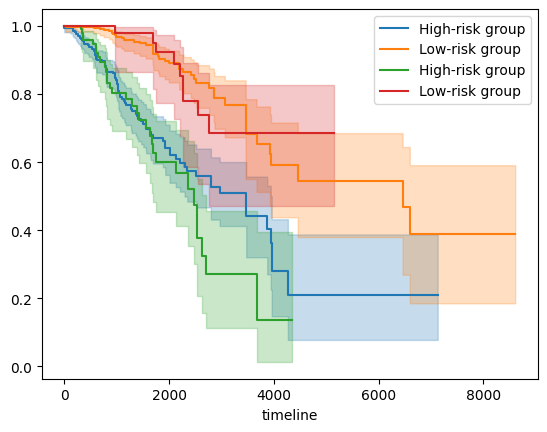

In [5]:
# In[ ]:


"""
Divide patients into high- and low-risk groups according to the median prognostic index among the tuning set patients
"""

condition1_tr = processed_tr["Prognosis_index"]>processed_tr["Prognosis_index"].median()
condition2_tr = processed_tr["Prognosis_index"]<=processed_tr["Prognosis_index"].median()

condition1_tes = processed_tes["Prognosis_index"]>processed_tr["Prognosis_index"].median()
condition2_tes = processed_tes["Prognosis_index"]<=processed_tr["Prognosis_index"].median()

upper_group_tr = processed_tr[condition1_tr]
lower_group_tr = processed_tr[condition2_tr]

upper_group_tes = processed_tes[condition1_tes]
lower_group_tes = processed_tes[condition2_tes]


# In[ ]:


"""
Draw Kaplan Meier curves for tuning set and testing set patients, respectively
"""
# Tuning set
T1_tr=upper_group_tr['OS.time']
E1_tr=upper_group_tr['OS']
T2_tr=lower_group_tr['OS.time']
E2_tr=lower_group_tr['OS']

kmf_tr = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf_tr.fit(T1_tr, E1_tr, label="High-risk group").plot(ax=ax)
ax = kmf_tr.fit(T2_tr, E2_tr, label="Low-risk group").plot(ax=ax)

# Testing set
T1_tes=upper_group_tes['OS.time']
E1_tes=upper_group_tes['OS']
T2_tes=lower_group_tes['OS.time']
E2_tes=lower_group_tes['OS']

kmf_tes = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf_tes.fit(T1_tes, E1_tes, label="High-risk group").plot(ax=ax)
ax = kmf_tes.fit(T2_tes, E2_tes, label="Low-risk group").plot(ax=ax)

# Log-rank tests for the KM curves
# Tuning set
results_tr=logrank_test(T1_tr, T2_tr, event_observed_A=E1_tr, event_observed_B=E2_tr)
results_tr.print_summary()

#Testing set
results_tes=logrank_test(T1_tes, T2_tes, event_observed_A=E1_tes, event_observed_B=E2_tes)
results_tes.print_summary()


# In[ ]:


"""
Save the high- and low-risk group patient information
"""

upper_group_tr.to_csv("saved_models/higher_PI_train.csv", index=False)
lower_group_tr.to_csv("saved_models/lower_PI_train.csv", index=False)
upper_group_tes.to_csv("saved_models/higher_PI_test.csv", index=False)
lower_group_tes.to_csv("saved_models/lower_PI_test.csv", index=False)


In [6]:
# In[ ]:


"""
DeepSHAP
"""

def load_data_deepshap(data, dtype):
    z = data.drop(["patient_id", "OS", "OS.time", "age", "race_white", "stage_i", "stage_ii", "Prognosis_index"], axis = 1).values.astype(np.float64)
    age = data.loc[:, ["age"]].values.astype(np.float64)
    stage_i = data.loc[:, ["stage_i"]].values.astype(np.float64)
    stage_ii = data.loc[:, ["stage_ii"]].values.astype(np.float64)
    race_white = data.loc[:, ["race_white"]].values.astype(np.float64)
    
    Z = torch.from_numpy(z).type(dtype)
    AGE = torch.from_numpy(age).type(dtype)
    STAGE_I = torch.from_numpy(stage_i).type(dtype)
    STAGE_II = torch.from_numpy(stage_ii).type(dtype)
    RACE_WHITE = torch.from_numpy(race_white).type(dtype)
    
    return(Z, AGE, STAGE_I, STAGE_II, RACE_WHITE)

def load_feature_deepshap(data):
    feature_data = data.drop(["patient_id", "OS", "OS.time", "Prognosis_index"], axis = 1)
    
    return feature_data

"""
These codes were adapted from the work of Withnell et al. https://academic.oup.com/bib/article/22/6/bbab315/6353242
Please check their original implementation of DeepSHAP for more details at https://github.com/zhangxiaoyu11/XOmiVAE
"""

class Explainer(object):
    """ This is the superclass of all explainers.
    """

    def shap_values(self, X):
        raise Exception("SHAP values not implemented for this explainer!")

    def attributions(self, X):
        return self.shap_values(X)

class PyTorchDeepExplainer(Explainer):

    def __init__(self, model, data, outputNumber, dim, explainLatentSpace):
        
        data = list(load_data_deepshap(data, dtype))
        
        # check if we have multiple inputs
        self.multi_input = False
        if type(data) == list:
            self.multi_input = True
        else:
            data = [data]
        self.data = data
        self.layer = None
        self.input_handle = None
        self.interim = False
        self.interim_inputs_shape = None
        self.expected_value = None  # to keep the DeepExplainer base happy
        if type(model) == tuple:

            self.interim = True
            model, layer = model
            model = model.eval()
            self.layer = layer
            self.add_target_handle(self.layer)

            # if we are taking an interim layer, the 'data' is going to be the input
            # of the interim layer; we will capture this using a forward hook
            with torch.no_grad():
                _ = model(*data)
                interim_inputs = self.layer.target_input
                if type(interim_inputs) is tuple:
                    # this should always be true, but just to be safe
                    self.interim_inputs_shape = [i.shape for i in interim_inputs]
                else:
                    self.interim_inputs_shape = [interim_inputs.shape]
            self.target_handle.remove()
            del self.layer.target_input
        self.model = model.eval()
        self.multi_output = False
        self.num_outputs = 1
        with torch.no_grad():
            outputs = model(*data)

            #This is where specifies whether we want to explain the mean or z output
            if type(outputs) != list:
                output = outputs
            else:
                output = outputs[outputNumber]
            self.outputNum=outputNumber
            # Chosen dimension
            self.dim=None
            self.explainLatent = False
            if explainLatentSpace:
                self.explainLatent=True
                self.dimension=dim
                output = output[:, dim]
                output = output.reshape(output.shape[0], 1)
            # also get the device everything is running on
            self.device = output.device
            if output.shape[1] > 1:
                self.multi_output = True
                self.num_outputs = output.shape[1]
            self.expected_value = output.mean(0).cpu().numpy()

    def add_target_handle(self, layer):

        input_handle = layer.register_forward_hook(get_target_input)
        self.target_handle = input_handle

    def add_handles(self, model, forward_handle, backward_handle):
        """
        Add handles to all non-container layers in the model.
        Recursively for non-container layers
        """
        handles_list = []
        model_children = list(model.children())
        if model_children:
            for child in model_children:
                handles_list.extend(self.add_handles(child, forward_handle, backward_handle))
        else:  # leaves
            handles_list.append(model.register_forward_hook(forward_handle))
            handles_list.append(model.register_backward_hook(backward_handle))

        return handles_list

    def remove_attributes(self, model):
        """
        Removes the x and y attributes which were added by the forward handles
        Recursively searches for non-container layers
        """
        for child in model.children():
            if 'nn.modules.container' in str(type(child)):
                self.remove_attributes(child)
            else:
                try:
                    del child.x
                except AttributeError:
                    pass
                try:
                    del child.y
                except AttributeError:
                    pass

    def gradient(self, idx, inputs):

        self.model.zero_grad()
        X = [x.requires_grad_() for x in inputs]
        
        output = self.model(*X)

        #Specify the output to change
        if type(output) != list:
            outputs = output
        else:
            outputs = output[self.outputNum]

        #Specify the dimension to explain
        if self.explainLatent==True:

            outputs = outputs[:, self.dimension]
            outputs = outputs.reshape(outputs.shape[0], 1)


        selected = [val for val in outputs[:, idx]]

        grads = []
        if self.interim:
            interim_inputs = self.layer.target_input
            for idx, input in enumerate(interim_inputs):
                grad = torch.autograd.grad(selected, input,
                                           retain_graph=True if idx + 1 < len(interim_inputs) else None,
                                           allow_unused=True)[0]
                if grad is not None:
                    grad = grad.cpu().numpy()
                else:
                    grad = torch.zeros_like(interim_inputs[idx]).cpu().numpy()
                grads.append(grad)
            del self.layer.target_input
            return grads, [i.detach().cpu().numpy() for i in interim_inputs]
        else:
            for idx, x in enumerate(X):
                grad = torch.autograd.grad(selected, x,
                                           retain_graph=True if idx + 1 < len(X) else None,
                                           allow_unused=True)[0]
                if grad is not None:
                    grad = grad.cpu().numpy()
                else:
                    grad = torch.zeros_like(X[idx]).cpu().numpy()
                grads.append(grad)
            return grads

    def shap_values(self, X, ranked_outputs=None, output_rank_order="max", check_additivity=False):

        # X ~ self.model_input
        # X_data ~ self.data
        
        X = list(load_data_deepshap(X, dtype))

        # check if we have multiple inputs
        if not self.multi_input:
            assert type(X) != list, "Expected a single tensor model input!"
            X = [X]
        else:
            assert type(X) == list, "Expected a list of model inputs!"


        X = [x.detach().to(self.device) for x in X]

        # if ranked output is given then this code is run and only the 'max' value given is explained
        if ranked_outputs is not None and self.multi_output:
            with torch.no_grad():
                model_output_values = self.model(*X)
                # Withnell's change to adjust for the additional outputs in VAE model
                model_output_values = model_output_values[self.outputNum]

            # rank and determine the model outputs that we will explain

            if output_rank_order == "max":
                _, model_output_ranks = torch.sort(model_output_values, descending=True)
            elif output_rank_order == "min":
                _, model_output_ranks = torch.sort(model_output_values, descending=False)
            elif output_rank_order == "max_abs":
                _, model_output_ranks = torch.sort(torch.abs(model_output_values), descending=True)
            else:
                assert False, "output_rank_order must be max, min, or max_abs!"

        else:
            # outputs and srray of 0s so we know we are explaining the first value
            model_output_ranks = (torch.ones((X[0].shape[0], self.num_outputs)).int() *
                                  torch.arange(0, self.num_outputs).int())

        # add the gradient handles

        handles = self.add_handles(self.model, add_interim_values, deeplift_grad)
        if self.interim:
            self.add_target_handle(self.layer)

        # compute the attributions
        output_phis = []

        for i in range(model_output_ranks.shape[1]):

            phis = []
            #phis are shapLundberg values

            if self.interim:
                for k in range(len(self.interim_inputs_shape)):
                    phis.append(np.zeros((X[0].shape[0], ) + self.interim_inputs_shape[k][1: ]))
            else:
                for k in range(len(X)):
                    phis.append(np.zeros(X[k].shape))
            #shape is 5 as testing 5 samples
            for j in range(X[0].shape[0]):

                # tile the inputs to line up with the background data samples
                tiled_X = [X[l][j:j + 1].repeat(
                                   (self.data[l].shape[0],) + tuple([1 for k in range(len(X[l].shape) - 1)])) for l
                           in range(len(X))]
                joint_x = [torch.cat((tiled_X[l], self.data[l]), dim=0) for l in range(len(X))]
                # run attribution computation graph
                feature_ind = model_output_ranks[j, i]
                sample_phis = self.gradient(feature_ind, joint_x)
                # assign the attributions to the right part of the output arrays
                if self.interim:
                    sample_phis, output = sample_phis
                    x, data = [], []
                    for i in range(len(output)):
                        x_temp, data_temp = np.split(output[i], 2)
                        x.append(x_temp)
                        data.append(data_temp)
                    for l in range(len(self.interim_inputs_shape)):
                        phis[l][j] = (sample_phis[l][self.data[l].shape[0]:] * (x[l] - data[l])).mean(0)
                else:
                    for l in range(len(X)):
                        phis[l][j] = (torch.from_numpy(sample_phis[l][self.data[l].shape[0]:]).to(self.device) * (X[l][j: j + 1] - self.data[l])).cpu().numpy().mean(0)
            output_phis.append(phis[0] if not self.multi_input else phis)


        # cleanup; remove all gradient handles
        for handle in handles:
            handle.remove()
        self.remove_attributes(self.model)
        if self.interim:
            self.target_handle.remove()

        if not self.multi_output:
            return output_phis[0]
        elif ranked_outputs is not None:
            # Withnell: returns a list... only want first value
            return output_phis, model_output_ranks
        else:
            return output_phis

# Module hooks


def deeplift_grad(module, grad_input, grad_output):
    """The backward hook which computes the deeplift
    gradient for an nn.Module
    """
    # first, get the module type
    module_type = module.__class__.__name__

    # first, check the module is supported
    if module_type in op_handler:

        if op_handler[module_type].__name__ not in ['passthrough', 'linear_1d']:
            return op_handler[module_type](module, grad_input, grad_output)
    else:
        print('Warning: unrecognized nn.Module: {}'.format(module_type))
        return grad_input


def add_interim_values(module, input, output):
    """The forward hook used to save interim tensors, detached
    from the graph. Used to calculate the multipliers
    """
    try:
        del module.x
    except AttributeError:
        pass
    try:
        del module.y
    except AttributeError:
        pass
    module_type = module.__class__.__name__

    if module_type in op_handler:
        func_name = op_handler[module_type].__name__

        # First, check for cases where we don't need to save the x and y tensors
        if func_name == 'passthrough':
            pass
        else:
            # check only the 0th input varies
            for i in range(len(input)):
                if i != 0 and type(output) is tuple:
                    assert input[i] == output[i], "Only the 0th input may vary!"
            # if a new method is added, it must be added here too. This ensures tensors
            # are only saved if necessary
            if func_name in ['maxpool', 'nonlinear_1d']:
                # only save tensors if necessary
                if type(input) is tuple:
                    setattr(module, 'x', torch.nn.Parameter(input[0].detach()))
                else:
                    setattr(module, 'x', torch.nn.Parameter(input.detach()))
                if type(output) is tuple:
                    setattr(module, 'y', torch.nn.Parameter(output[0].detach()))
                else:
                    setattr(module, 'y', torch.nn.Parameter(output.detach()))
            if module_type in failure_case_modules:
                input[0].register_hook(deeplift_tensor_grad)


def get_target_input(module, input, output):
    """A forward hook which saves the tensor - attached to its graph.
    Used if we want to explain the interim outputs of a model
    """
    try:
        del module.target_input
    except AttributeError:
        pass
    setattr(module, 'target_input', input)

# Withnell:
# From the documentation: "The current implementation will not have the presented behavior for
# complex Module that perform many operations. In some failure cases, grad_input and grad_output
# will only contain the gradients for a subset of the inputs and outputs.
# The tensor hook below handles such failure cases (currently, MaxPool1d). In such cases, the deeplift
# grad should still be computed, and then appended to the complex_model_gradients list. The tensor hook
# will then retrieve the proper gradient from this list.


failure_case_modules = ['MaxPool1d']


def deeplift_tensor_grad(grad):
    return_grad = complex_module_gradients[-1]
    del complex_module_gradients[-1]
    return return_grad


complex_module_gradients = []


def passthrough(module, grad_input, grad_output):
    """No change made to gradients"""
    return None


def maxpool(module, grad_input, grad_output):
    pool_to_unpool = {
        'MaxPool1d': torch.nn.functional.max_unpool1d,
        'MaxPool2d': torch.nn.functional.max_unpool2d,
        'MaxPool3d': torch.nn.functional.max_unpool3d
    }
    pool_to_function = {
        'MaxPool1d': torch.nn.functional.max_pool1d,
        'MaxPool2d': torch.nn.functional.max_pool2d,
        'MaxPool3d': torch.nn.functional.max_pool3d
    }
    delta_in = module.x[: int(module.x.shape[0] / 2)] - module.x[int(module.x.shape[0] / 2):]
    dup0 = [2] + [1 for i in delta_in.shape[1:]]
    # we also need to check if the output is a tuple
    y, ref_output = torch.chunk(module.y, 2)
    cross_max = torch.max(y, ref_output)
    diffs = torch.cat([cross_max - ref_output, y - cross_max], 0)

    # all of this just to unpool the outputs
    with torch.no_grad():
        _, indices = pool_to_function[module.__class__.__name__](
            module.x, module.kernel_size, module.stride, module.padding,
            module.dilation, module.ceil_mode, True)
        xmax_pos, rmax_pos = torch.chunk(pool_to_unpool[module.__class__.__name__](
            grad_output[0] * diffs, indices, module.kernel_size, module.stride,
            module.padding, list(module.x.shape)), 2)
    org_input_shape = grad_input[0].shape  # for the maxpool 1d
    grad_input = [None for _ in grad_input]
    grad_input[0] = torch.where(torch.abs(delta_in) < 1e-7, torch.zeros_like(delta_in),
                           (xmax_pos + rmax_pos) / delta_in).repeat(dup0)
    if module.__class__.__name__ == 'MaxPool1d':
        complex_module_gradients.append(grad_input[0])
        # the grad input that is returned doesn't matter, since it will immediately be
        # be overridden by the grad in the complex_module_gradient
        grad_input[0] = torch.ones(org_input_shape)
    return tuple(grad_input)


def linear_1d(module, grad_input, grad_output):
    """No change made to gradients."""
    return None


def nonlinear_1d(module, grad_input, grad_output):
    delta_out = module.y[: int(module.y.shape[0] / 2)] - module.y[int(module.y.shape[0] / 2):]

    delta_in = module.x[: int(module.x.shape[0] / 2)] - module.x[int(module.x.shape[0] / 2):]
    dup0 = [2] + [1 for i in delta_in.shape[1:]]
    # handles numerical instabilities where delta_in is very small by
    # just taking the gradient in those cases
    grads = [None for _ in grad_input]
    grads[0] = torch.where(torch.abs(delta_in.repeat(dup0)) < 1e-6, grad_input[0],
                           grad_output[0] * (delta_out / delta_in).repeat(dup0))
    return tuple(grads)


op_handler = {}

# passthrough ops, where we make no change to the gradient
op_handler['Dropout3d'] = passthrough
op_handler['Dropout2d'] = passthrough
op_handler['Dropout'] = passthrough
op_handler['AlphaDropout'] = passthrough

op_handler['Conv1d'] = linear_1d
op_handler['Conv2d'] = linear_1d
op_handler['Conv3d'] = linear_1d
op_handler['ConvTranspose1d'] = linear_1d
op_handler['ConvTranspose2d'] = linear_1d
op_handler['ConvTranspose3d'] = linear_1d
op_handler['Linear'] = linear_1d
op_handler['AvgPool1d'] = linear_1d
op_handler['AvgPool2d'] = linear_1d
op_handler['AvgPool3d'] = linear_1d
op_handler['AdaptiveAvgPool1d'] = linear_1d
op_handler['AdaptiveAvgPool2d'] = linear_1d
op_handler['AdaptiveAvgPool3d'] = linear_1d
op_handler['BatchNorm1d'] = linear_1d
op_handler['BatchNorm2d'] = linear_1d
op_handler['BatchNorm3d'] = linear_1d

op_handler['LeakyReLU'] = nonlinear_1d
op_handler['ReLU'] = nonlinear_1d
op_handler['ELU'] = nonlinear_1d
op_handler['Sigmoid'] = nonlinear_1d
op_handler["Tanh"] = nonlinear_1d
op_handler["Softplus"] = nonlinear_1d
op_handler['Softmax'] = nonlinear_1d

op_handler['MaxPool1d'] = maxpool
op_handler['MaxPool2d'] = maxpool
op_handler['MaxPool3d'] = maxpool



In [8]:
# In[ ]:


def getTopShapValues(shap_vals, numberOfTopFeatures, numberOfLatents, path, absolute=True):
    multiple_input = False
    if type(shap_vals) == list:
        multiple_input = True
        shap_values = None
        for l in range(len(shap_vals)):
            if shap_values is not None:
                shap_values = np.concatenate((shap_values, shap_vals[l]), axis=1)
            else:
                shap_values = shap_vals[l]
        shap_vals = shap_values
    
    if absolute:
        vals = np.abs(shap_vals).mean(0)
    else:
        vals = shap_vals.mean(0)
    
    z_count = np.array(list(range(1, numberOfLatents+1, 1))).astype('str')
    z_names = np.char.add('Z_', z_count).tolist()
    
    if multiple_input:
        feature_names = z_names + ['age', 'stage_i', 'stage_ii', 'race_white']
    else:
        feature_names = z_names

    feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                      columns=['features', 'importance_vals'])
    feature_importance.sort_values(by=['importance_vals'], ascending=False, inplace=True)

    mostImp_shap_values = feature_importance.head(numberOfTopFeatures)
    print(mostImp_shap_values)

    feature_importance.to_csv(path + "/sup_feature_imp.csv")
    """
    print(mostImp_shap_values)
    print("least importance absolute values")
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=True, inplace=True)
    leastImp_shap_values = feature_importance.head(numberOfTopFeatures)
    print(leastImp_shap_values)
    """
    return mostImp_shap_values


# In[ ]:


def SupShapExplainer(train_overall_df, path, dimension):
    #initialize LFSurv network with the set of optimal hyperparameters found via grid search during training/validation process
    LFSurv_model = LFSurv(16, 8, 0.5, 0.3)
    
    #load trained model
    LFSurv_model.load_state_dict(torch.load('saved_models/sup_checkpoint_overall.pt', map_location=torch.device('cpu')))
    
    condition1 = train_overall_df["Prognosis_index"]>train_overall_df["Prognosis_index"].median()
    condition2 = train_overall_df["Prognosis_index"]<=train_overall_df["Prognosis_index"].median()
    
    #select certain data
    upper_group_sample = splitExprandSample(condition=condition1, sampleSize=100, expr=train_overall_df)
    lower_group_sample = splitExprandSample(condition=condition2, sampleSize=100, expr=train_overall_df)
    
    e = PyTorchDeepExplainer(LFSurv_model, lower_group_sample, outputNumber=0, dim=dimension, explainLatentSpace=False)
    print("calculating shap values")
    shap_values_obtained = e.shap_values(upper_group_sample)
    
    print("calculated shap values")
    # modify the number of latents and number of top features accordingly
    most_imp  = getTopShapValues(shap_vals=shap_values_obtained, numberOfTopFeatures=12, numberOfLatents=16, path=path, absolute=True)
    
    return most_imp


# In[ ]:


most_important_features = SupShapExplainer(train_overall_df=processed_tr, path='saved_models', dimension=0)


# In[ ]:


calculating shap values


/cloud-home/U1039935/.magellan/conda/envs/VAE/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


calculated shap values
    features  importance_vals
16       age         0.275928
18  stage_ii         0.191595
17   stage_i         0.165391
4        Z_5         0.058095
7        Z_8         0.057876
1        Z_2         0.049013
8        Z_9         0.033313
2        Z_3         0.031795
15      Z_16         0.030386
11      Z_12         0.029462
10      Z_11         0.028897
3        Z_4         0.026658


In [9]:
most_important_features

,features,importance_vals
16,age,0.275928
18,stage_ii,0.191595
17,stage_i,0.165391
4,Z_5,0.058095
7,Z_8,0.057876
1,Z_2,0.049013
8,Z_9,0.033313
2,Z_3,0.031795
15,Z_16,0.030386
11,Z_12,0.029462
